In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import string
import torch
from torch import nn
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from transformers import BertTokenizer, BertModel, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df = pd.read_csv("reviews.csv")
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2992450,15066586,2014-07-01,16827297,Kristen,Large apartment; nice kitchen and bathroom. Ke...
1,2992450,21810844,2014-10-24,22648856,Christopher,"This may be a little late, but just to say Ken..."
2,2992450,27434334,2015-03-04,45406,Altay,The apartment was very clean and convenient to...
3,2992450,28524578,2015-03-25,5485362,John,Kenneth was ready when I got there and arrange...
4,2992450,35913434,2015-06-23,15772025,Jennifer,We were pleased to see how 2nd Street and the ...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     25991 non-null  int64 
 1   id             25991 non-null  int64 
 2   date           25991 non-null  object
 3   reviewer_id    25991 non-null  int64 
 4   reviewer_name  25991 non-null  object
 5   comments       25983 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.2+ MB


In [12]:
df['comments'].fillna('', inplace=True)

/tmp/ipython-input-12-447818558.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['comments'].fillna('', inplace=True)


In [13]:
df.shape

(25991, 6)

In [14]:
df = df.iloc[:100, :]

In [ ]:

nltk.download('stopwords')
nltk.download('punkt_tab')
stp = set(stopwords.words('english'))

In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
def cleaning(text) :
  text = BeautifulSoup(text, 'html.parser').get_text()
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word.isalpha() and word not in stp]
  return ' '.join(tokens)

df['clean_comments'] = df['comments'].apply(cleaning)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

__Fine tuned BERT Model__

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [21]:
def embedding(text) :
  tokens = tokenizer(text, padding=True, truncation=True, max_length = 512, return_tensors = 'pt')
  tokens = {key : value.to(device) for key, value in tokens.items()}
  with torch.no_grad() :
    op = model(**tokens)
  return op.last_hidden_state.mean(1).cpu().squeeze().numpy()

df['embeddings'] = df['clean_comments'].apply(embedding)
df[['embeddings']].head()

,embeddings
0,"[0.3648549, 0.10123699, 0.59573257, 0.04224497..."
1,"[-0.108059555, 0.16779259, 0.627591, 0.0081775..."
2,"[0.12527198, 0.037915114, 0.60106444, -0.03166..."
3,"[0.12643524, 0.036183346, 0.6149729, -0.072125..."
4,"[0.14063631, 0.14142396, 0.658824, -0.00681539..."


In [ ]:
# cant add any ann as there is no labels provided !!!

__Pretrained PIPELINE__

In [24]:
sent_analyzer = pipeline('sentiment-analysis', device = 0 if torch.cuda.is_available() else -1)

def analyze(text) :
  result = sent_analyzer(text)[0]
  return result['label'], result['score']

df[['sentiment_label', 'sentiment_score']] = df['clean_comments'].apply(lambda x : pd.Series(analyze(x)))
df[['comments', 'sentiment_label', 'sentiment_score']].head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,comments,sentiment_label,sentiment_score
0,Large apartment; nice kitchen and bathroom. Ke...,POSITIVE,0.991924
1,"This may be a little late, but just to say Ken...",POSITIVE,0.980402
2,The apartment was very clean and convenient to...,POSITIVE,0.506011
3,Kenneth was ready when I got there and arrange...,POSITIVE,0.763582
4,We were pleased to see how 2nd Street and the ...,POSITIVE,0.742758


__Text Summarization using t5-small and bart model__

In [ ]:
# summarizer = pipeline('summarization', model = 'facebook/bart-large-cnn')
summarizer = pipeline('summarization', model = 't5-small', device = 0 if torch.cuda.is_available() else -1)
def summarize(text) :
  if len(text.split()) > 50 :
    summary = summarizer(text, max_length = 51, min_length = 25, do_sample = False)[0]['summary_text']
  else :
    summary = text
  return summary

df['summary'] = df['comments'].apply(summarize)
df[['comments', 'summary']].head()

__Topic Identification__

In [36]:
tfidf = TfidfVectorizer(max_features = 1000)
matrix = tfidf.fit_transform(df['clean_comments'])
features = tfidf.get_feature_names_out()

def keywords(row, n = 10) :
  top_indexes = row.toarray()[0].argsort()[::-1]
  top_indexes = top_indexes[:n]
  topics = [features[i] for i in top_indexes]
  return topics

#df['topics'] = pd.DataFrame(matrix.toarray()).apply(keywords, axis = 1)
df['topics'] = [keywords(r) for r in matrix]
df[['comments', 'topics']].head()

,comments,topics
0,Large apartment; nice kitchen and bathroom. Ke...,"[nice, drinks, unsafe, never, main, heard, ups..."
1,"This may be a little late, but just to say Ken...","[us, climb, fairly, hill, round, supplies, sit..."
2,The apartment was very clean and convenient to...,"[one, thing, huge, coin, keep, flip, tiny, fri..."
3,Kenneth was ready when I got there and arrange...,"[like, apartment, neighbor, privacy, br, refri..."
4,We were pleased to see how 2nd Street and the ...,"[pleased, see, windows, enjoy, sure, renovated..."


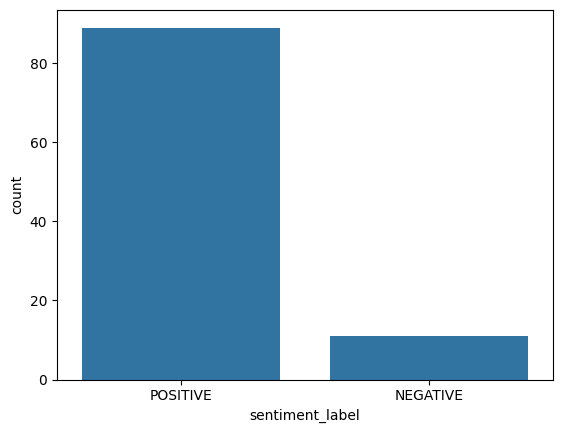

In [37]:
sns.countplot(data = df, x = 'sentiment_label')
plt.show()

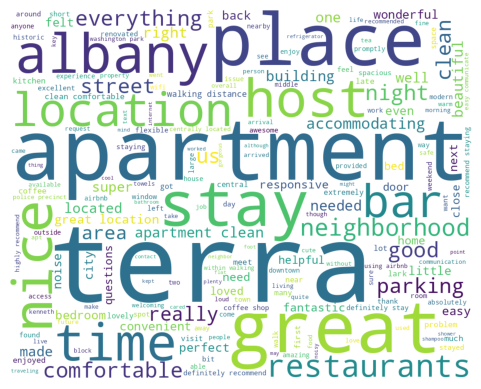

In [39]:
from wordcloud import WordCloud
text = ' '.join(df['clean_comments'])
wordcloud = WordCloud(width = 1000, height = 800, background_color = 'white').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
print("Review: ", df['comments'][0], '\n')
print("Cleaned Review: ", df['clean_comments'][0], '\n')
print("Sentiment Label: ", df['sentiment_label'][0], '\n')
print("Sentiment Score: ", df['sentiment_score'][0], '\n')
print("Summary: ", df['summary'][0], '\n')
print("Topics: ", df['topics'][0], '\n')

Review:  Large apartment; nice kitchen and bathroom. Kenneth left drinks for us which was so nice. His cousin lives upstairs, and she was very nice and helpful, too. The internet only worked about half the time, and everything on the street can be heard from the main bedroom. Wonderful stay- it was exactly what we needed. It is not in the best area of town, but I never felt unsafe.  

Cleaned Review:  large apartment nice kitchen bathroom kenneth left drinks us nice cousin lives upstairs nice helpful internet worked half time everything street heard main bedroom wonderful exactly needed best area town never felt unsafe 

Sentiment Label:  POSITIVE 

Sentiment Score:  0.9919243454933167 

Summary:  the internet only worked about half the time, and everything on the street can be heard from the main bedroom . it was exactly what we needed, but I never felt unsafe . 

Topics:  ['nice', 'drinks', 'unsafe', 'never', 'main', 'heard', 'upstairs', 'half', 'exactly', 'cousin'] 

